# NYC Taxi Requests Prediction

To demonstrate the demand forecast in each grid at 5min, 15min and 30min slot, we use the yellow New York City Taxi and Limousine Commission (TLC) Trip Record Data between Jan 2018 and June 2018 in Manhattan from AWS public datasets as source data (https://registry.opendata.aws/nyc-tlc-trip-records-pds/). We split the dataset into train part (2018.01.01-2018.05.31) and validate part (2018.06.01-2018.06.30). We demonstrate 4 methods to forecast demand: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE).

We mainly use linear regression algorithm as the baseline algorithm, and use XGBoost as the main algorithm. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

To run this notebook, you have to download trip data from Amazon S3 bucket to nyc-tlc directory in your computer:

- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-02.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-03.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-04.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv
- https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-06.csv
- https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
- https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip (unzip)

After download, your local directory structure should be:

```
nyc-tlc
├── misc
│   ├── taxi\ _zone_lookup.csv
│   ├── taxi_zones
│   │   ├── taxi_zones.dbf
│   │   ├── taxi_zones.prj
│   │   ├── taxi_zones.sbn
│   │   ├── taxi_zones.sbx
│   │   ├── taxi_zones.shp
│   │   ├── taxi_zones.shp.xml
│   │   └── taxi_zones.shx
│   └── taxi_zones.zip
└── trip\ data
    ├── yellow_tripdata_2018-01.csv
    ├── yellow_tripdata_2018-02.csv
    ├── yellow_tripdata_2018-03.csv
    ├── yellow_tripdata_2018-04.csv
    ├── yellow_tripdata_2018-05.csv
    └── yellow_tripdata_2018-06.csv

3 directories, 15 files
```

## Basic Prepare

We import all useful packages, and set the `first_datetime` to 2018-01-01 00:00:00, and `last_datetime` to 2018-07-01 00:00:00. We split the dataset into two parts: train and validate, by setting the `train_valid_split_datetime` to 2018-06-01 00:00:00.

In [1]:
# imports
import time
import pickle
import datetime
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error as mae

/usr/local/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# global setting
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [4]:
# time setting
first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_5min_id = get_5min_id(first_datetime)
first_15min_id = get_15min_id(first_datetime)
first_30min_id = get_30min_id(first_datetime)
print('first_5min_id:', first_5min_id)
print('first_15min_id:', first_15min_id)
print('first_30min_id:', first_30min_id)

last_5min_id = get_5min_id(last_datetime)
last_15min_id = get_15min_id(last_datetime)
last_30min_id = get_30min_id(last_datetime)
print('last_5min_id:', last_5min_id)
print('last_15min_id:', last_15min_id)
print('last_30min_id:', last_30min_id)

train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-07-01 00:00:00
train_valid_split_datetime: 2018-06-01 00:00:00
first_5min_id: 0.0
first_15min_id: 0.0
first_30min_id: 0.0
last_5min_id: 52128.0
last_15min_id: 17376.0
last_30min_id: 8688.0
train_valid_split_5min_id: 43488.0
train_valid_split_15min_id: 14496.0
train_valid_split_30min_id: 7248.0


## Taxi Zones

Since newest NYC Taxi dataset only provides `PULocationID` and `DOLocationID`, instead of `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`, we can only predict requests in each `PULocationID` (zone). We load [taxi _zone_lookup.csv] and [taxi_zones.shp], and use `geopandas` to visualize the zones in Manhattan (69 in total).

In [5]:
# Manhattan taxi zone lookup
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
manhattan_location_num = len(manhattan_location_ids)
print('manhattan_location_ids:', manhattan_location_ids.shape, manhattan_location_ids)
print('manhattan_location_num:', manhattan_location_num)

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
manhattan_location_num: 69


In [6]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [7]:
# Manhattan taxi zones shape
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


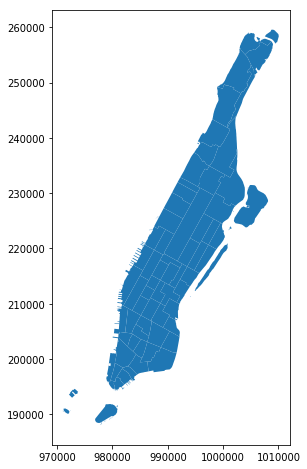

In [8]:
# visualize Manhattan taxi zones shape
taxi_zones_shape.plot()

## Data Prepare

We load all data from [nyc-tlc/trip data/] between Jan and June 2018, and filter abnormal data. We use `matplotlib` and `geopandas` to visualize some columns and help us to understand the trip data.

In [9]:
# filter abnormal data: tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, trip duration, trip_speed, total_amount, etc.
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] > 0]
    print('filter trip_distance:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']*3600
    print('trip_speed:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] > 0]
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] <= 200]
    print('filter trip_speed:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [10]:
# load Manhattan data
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
    sample_manhattan = filter_abnormal_data(sample)
else:
    for m in range(1, 7):  # (1, 7)
        start = time.time()
        sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
        print('read_csv 2018-0'+str(m)+':', time.time()-start)
        sample_1 = filter_abnormal_data(sample_1)
        print('filter_abnormal_data:', time.time()-start)
        if m == 1:
            sample_manhattan = sample_1
        else:
            sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        print('concat:', time.time()-start)
print('sample_manhattan:', sample_manhattan.shape)

# filter too large total_amount, trip_distance, trip_duration
start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

read_csv 2018-01: 21.130527019500732
filter PULocationID: (7965703, 17) 5.944800138473511
tpep_pickup_datetime: 7.815284967422485
tpep_dropoff_datetime: 9.407067060470581
filter tpep_pickup_datetime first_datetime: (7965469, 17) 11.380733013153076
filter tpep_pickup_datetime last_datetime: (7965463, 17) 12.565469026565552
filter trip_distance: (7934895, 17) 13.420119047164917
trip_duration: 13.699558019638062
filter trip_duration: (7934778, 18) 15.527584075927734
trip_speed: 15.628881931304932
filter trip_speed: (7931601, 19) 18.581295251846313
filter total_amount: (7928563, 19) 19.486891984939575
filter_abnormal_data: 41.01275277137756
concat: 41.012929916381836
read_csv 2018-02: 18.124281644821167
filter PULocationID: (7767881, 17) 3.859714984893799
tpep_pickup_datetime: 5.4371631145477295
tpep_dropoff_datetime: 6.914047956466675
filter tpep_pickup_datetime first_datetime: (7767797, 17) 8.010439157485962
filter tpep_pickup_datetime last_datetime: (7767791, 17) 8.841553211212158
filte

In [11]:
# append, change and drop columns
start = time.time()
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)
#sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
#print('tpep_pickup_date:', time.time()-start)
#sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
#print('tpep_dropoff_date:', time.time()-start)
#sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].dt.year
#print('tpep_pickup_year:', time.time()-start)
#sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].dt.month
#print('tpep_pickup_month:', time.time()-start)
#sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].dt.day
#print('tpep_pickup_day:', time.time()-start)
#sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].dt.hour
#print('tpep_pickup_hour:', time.time()-start)
#sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].dt.weekday
#print('tpep_pickup_weekday:', time.time()-start)
#sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
#print('is_weekend:', time.time()-start)
#sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
#print('is_morning_peak:', time.time()-start)
#sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
#print('is_evening_peak:', time.time()-start)

#store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
#print('store_and_fwd_flag_dummy:', time.time()-start)
#passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
#print('passenger_count_dummy:', time.time()-start)
#RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
#print('RatecodeID_dummy:', time.time()-start)
#payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
#print('payment_type_dummy:', time.time()-start)

#sample_manhattan = pd.concat([sample_manhattan, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)  # TODO memory error
#print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'
print('sample_manhattan.shape:', sample_manhattan.shape)

store_and_fwd_flag: 18.99100375175476
tpep_pickup_5min_id: 25.410267114639282
tpep_pickup_15min_id: 29.60542392730713
tpep_pickup_30min_id: 34.472368001937866
sample_manhattan.shape: (48632711, 20)


In [12]:
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,9.091,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,8.917,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,8.113,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,18.840,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,8.427,1.000,0.000,0.000


In [13]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000,48632711.000
mean,1.568,1.602,2.332,1.016,1.000,164.233,161.415,1.306,11.141,0.325,0.499,1.631,0.158,0.300,14.057,766.998,10.662,26104.130,8701.044,4350.272
std,0.496,1.250,2.642,0.202,0.000,66.538,69.231,0.475,8.240,0.407,0.027,2.006,1.137,0.002,10.229,567.381,5.321,14787.540,4929.180,2464.590
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-60.000,0.000,0.000,0.000,0.000,0.300,1.000,0.004,0.000,0.000,0.000
25%,1.000,1.000,0.920,1.000,1.000,113.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,8.300,381.000,7.256,13235.000,4411.000,2205.000
50%,2.000,1.000,1.500,1.000,1.000,162.000,162.000,1.000,9.000,0.000,0.500,1.360,0.000,0.300,11.300,624.000,9.631,26155.000,8718.000,4359.000
75%,2.000,2.000,2.600,1.000,1.000,234.000,233.000,2.000,13.000,0.500,0.500,2.260,0.000,0.300,15.960,990.000,12.763,38676.000,12892.000,6446.000
max,4.000,192.000,55.410,99.000,1.000,263.000,265.000,4.000,420.000,66.660,60.800,411.500,355.350,0.600,433.800,8337.000,200.000,52127.000,17375.000,8687.000


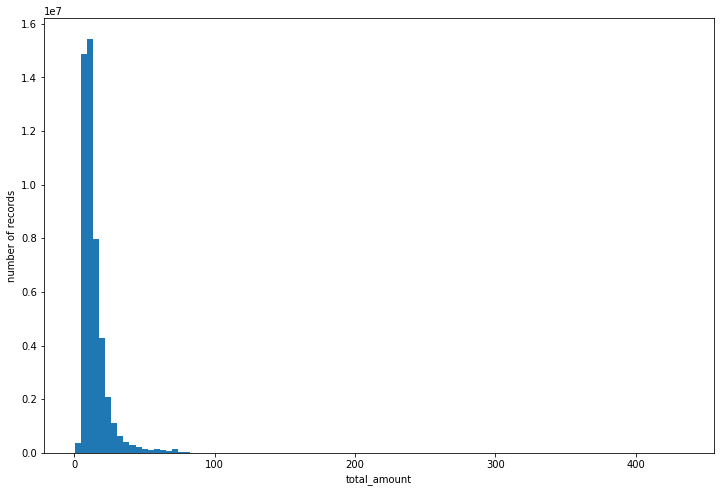

In [14]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

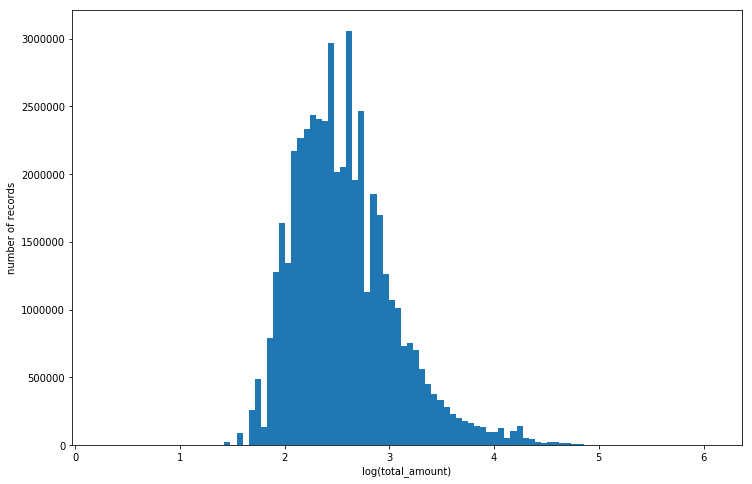

In [15]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()

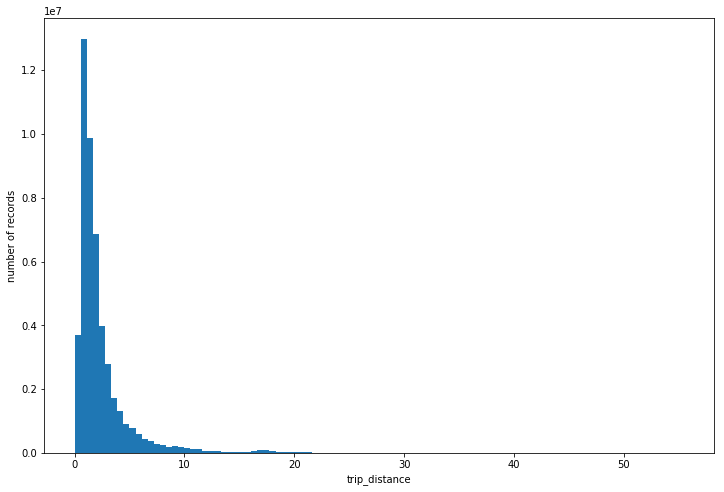

In [16]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

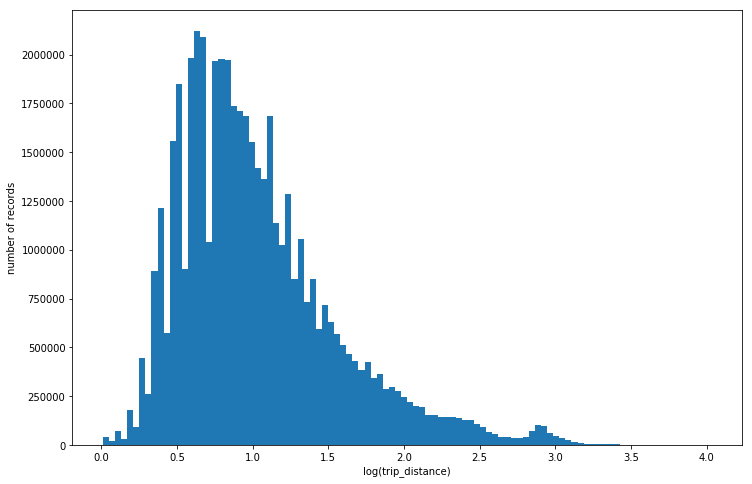

In [17]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()

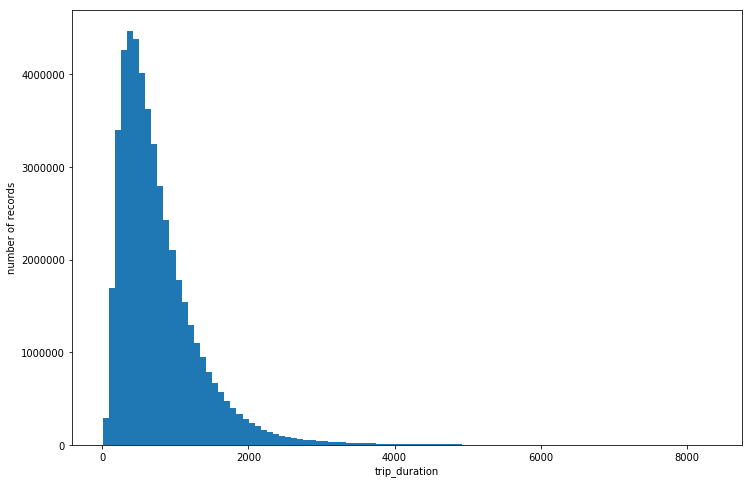

In [18]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

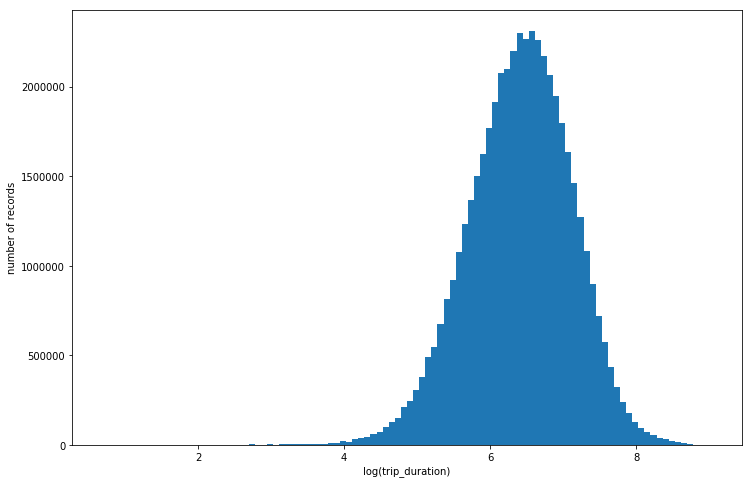

In [19]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()

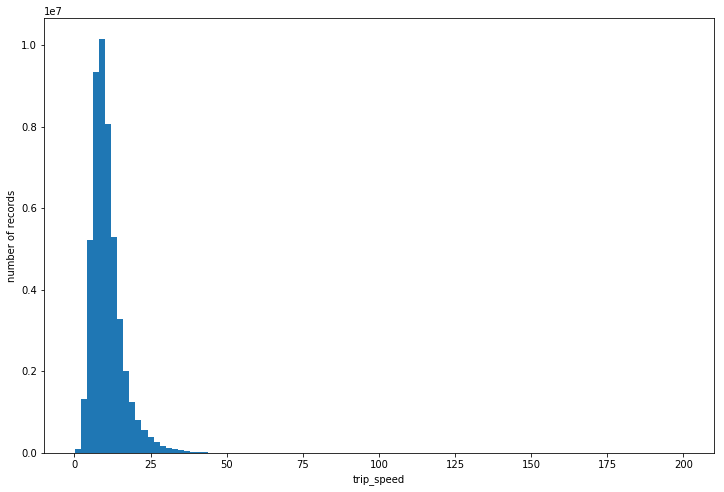

In [20]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

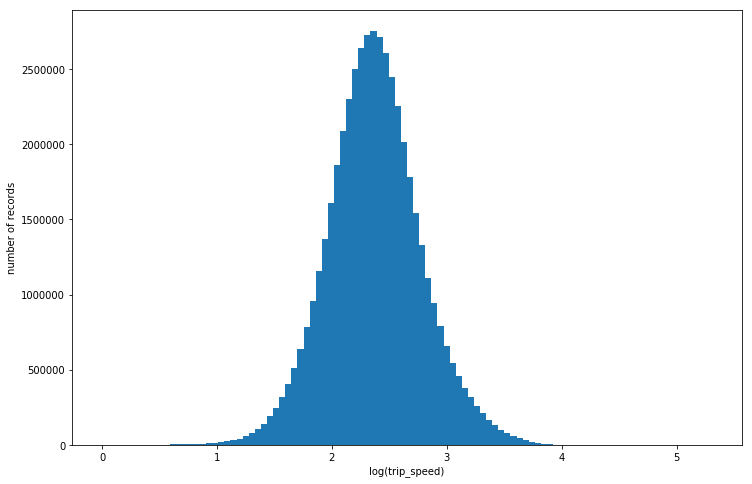

In [21]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()

In [22]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group.head()

,VendorID
PULocationID,
4,116900
12,21911
13,481375
24,162278
41,212347


In [23]:
taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
print('taxi_zones_shape_requests:', taxi_zones_shape_requests.shape)

taxi_zones_shape_requests: (69, 8)


In [24]:
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",116900.000
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",21911.000
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",481375.000
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",162278.000
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",212347.000


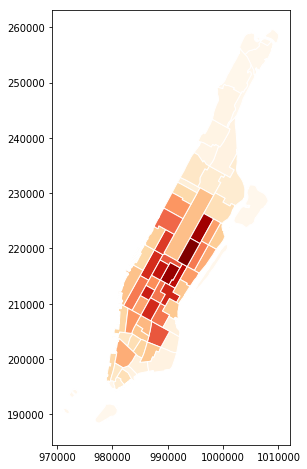

In [25]:
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

## Feature Prepare

We set the `5min_id`, `15min_id` and `30min_id` to represent 5min, 15min and 30min slot. For example, time between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 has a `5min_id` as 0, and time between 2018-01-01 00:05:00 and 2018-01-01 00:10:00 has a `5min_id` as 1, and the similar with `15min_id` and `30min_id`. For each `Xmin_id` (X represents 5, 15 or 30), we predict the requests in all 69 zones. We have some `static features` such as `month`, `day`, `hour`, `weekday`, `is_weekend`, `is_morning_peak`, `is_evening_pick` for all `Xmin_id` and zones. Also we can extend more static features such as weather and zone features. Other `dynamic features` includes requests in `5min ago`, `10min ago`, `15min ago`, `7days ago`, etc. Also we can extend more dynamic features such as total passengers in 5min ago. At last, we generate 34 features for each `Xmin_id` and zone.

In [26]:
def get_all_index_and_static(last_id, id_name):
    start = time.time()
    all_id = np.array([i for i in range(int(last_id)) for _ in range(manhattan_location_num)])
    all_LocationID = np.array([i for _ in range(int(last_id)) for i in manhattan_location_ids])
    print('all_id:', all_id.shape, all_id)
    print('all_LocationID:', all_LocationID.shape, all_LocationID)

    all_index = pd.DataFrame({id_name: all_id, 'LocationID': all_LocationID})
    all_index.set_index([id_name, 'LocationID'], inplace=True)
    print('all_index:', all_index.shape)

    all_static = pd.DataFrame({id_name: all_id, 'LocationID': all_LocationID})
    all_static['tpep_pickup_datetime'] = pd.to_timedelta(all_static[id_name]*5*60, unit='s') + first_datetime
    print('tpep_pickup_datetime:', time.time()-start)
    #all_static['tpep_pickup_year'] = all_static['tpep_pickup_datetime'].dt.year
    #print('tpep_pickup_year:', time.time()-start)
    all_static['tpep_pickup_month'] = all_static['tpep_pickup_datetime'].dt.month
    print('tpep_pickup_month:', time.time()-start)
    all_static['tpep_pickup_day'] = all_static['tpep_pickup_datetime'].dt.day
    print('tpep_pickup_day:', time.time()-start)
    all_static['tpep_pickup_hour'] = all_static['tpep_pickup_datetime'].dt.hour
    print('tpep_pickup_hour:', time.time()-start)
    all_static['tpep_pickup_weekday'] = all_static['tpep_pickup_datetime'].dt.weekday
    print('tpep_pickup_weekday:', time.time()-start)
    all_static['is_weekend'] = all_static['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
    print('is_weekend:', time.time()-start)
    all_static['is_morning_peak'] = all_static['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
    print('is_morning_peak:', time.time()-start)
    all_static['is_evening_peak'] = all_static['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
    print('is_evening_peak:', time.time()-start)
    all_static.drop(['tpep_pickup_datetime'], axis=1, inplace=True)
    all_static.set_index([id_name, 'LocationID'], inplace=True)
    print('all_static:', all_static.shape)
    return all_index, all_static

In [27]:
all_5min_index, all_5min_static = get_all_index_and_static(last_5min_id, 'tpep_pickup_5min_id')
all_15min_index, all_15min_static = get_all_index_and_static(last_15min_id, 'tpep_pickup_15min_id')
all_30min_index, all_30min_static = get_all_index_and_static(last_30min_id, 'tpep_pickup_30min_id')

all_id: (3596832,) [    0     0     0 ... 52127 52127 52127]
all_LocationID: (3596832,) [  4  12  13 ... 261 262 263]
all_index: (3596832, 0)
tpep_pickup_datetime: 1.3961381912231445
tpep_pickup_month: 1.5202782154083252
tpep_pickup_day: 1.64546799659729
tpep_pickup_hour: 1.7719800472259521
tpep_pickup_weekday: 1.9122450351715088
is_weekend: 3.2231602668762207
is_morning_peak: 4.636240005493164
is_evening_peak: 6.037522077560425
all_static: (3596832, 7)
all_id: (1198944,) [    0     0     0 ... 17375 17375 17375]
all_LocationID: (1198944,) [  4  12  13 ... 261 262 263]
all_index: (1198944, 0)
tpep_pickup_datetime: 0.40462493896484375
tpep_pickup_month: 0.4497816562652588
tpep_pickup_day: 0.49506592750549316
tpep_pickup_hour: 0.5419657230377197
tpep_pickup_weekday: 0.6005749702453613
is_weekend: 1.0910627841949463
is_morning_peak: 1.5910847187042236
is_evening_peak: 2.0506439208984375
all_static: (1198944, 7)
all_id: (599472,) [   0    0    0 ... 8687 8687 8687]
all_LocationID: (599472,

In [28]:
all_5min_index.head()

Empty DataFrame
Columns: []
Index: [(0, 4), (0, 12), (0, 13), (0, 24), (0, 41)]

In [29]:
all_5min_index.tail()

Empty DataFrame
Columns: []
Index: [(52127, 246), (52127, 249), (52127, 261), (52127, 262), (52127, 263)]

In [30]:
all_5min_static.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
0                   4                    0                0                0  
                    12                   0                0                0  
                    13                   0                0                0  
                    24                   0                0                0  
                    41                   0                0                0

In [31]:
all_5min_static.tail()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
52127               246                         6               30   
                    249                         6               30   
                    261                         6               30   
                    262                         6               30   
                    263                         6               30   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
52127               246                       23                    5   
                    249                       23                    5   
                    261                       23                    5   
                    262                       23                    5   
                    263                       23                    5   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
52127               246                  1                0                0  
                    249                  1                0                0  
                    261                  1                0                0  
                    262                  1                0                0  
                    263                  1                0                0

In [32]:
def get_sample_group(id_name):
    sample_group = sample_manhattan.groupby([id_name, 'PULocationID'])
    sample_count = sample_group.count()
    sample_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_count:', sample_count.shape)
    sample_mean = sample_group.mean()
    sample_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_mean:', sample_mean.shape)
    sample_sum = sample_group.sum()
    sample_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_sum:', sample_sum.shape)
    sample_dropoff_group = sample_manhattan.groupby([id_name, 'DOLocationID'])
    sample_dropoff_count = sample_dropoff_group.count()
    sample_dropoff_count.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_count:', sample_dropoff_count.shape)
    sample_dropoff_mean = sample_dropoff_group.mean()
    sample_dropoff_mean.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_mean:', sample_dropoff_mean.shape)
    sample_dropoff_sum = sample_dropoff_group.sum()
    sample_dropoff_sum.index.rename([id_name, 'LocationID'], inplace=True)
    print('sample_dropoff_sum:', sample_dropoff_sum.shape)
    return sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum

In [33]:
sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum = get_sample_group('tpep_pickup_5min_id')
sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum = get_sample_group('tpep_pickup_15min_id')
sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum = get_sample_group('tpep_pickup_30min_id')

sample_count: (2822402, 22)
sample_mean: (2822402, 22)
sample_sum: (2822402, 22)
sample_dropoff_count: (4466584, 22)
sample_dropoff_mean: (4466584, 22)
sample_dropoff_sum: (4466584, 22)
sample_count: (1015199, 22)
sample_mean: (1015199, 22)
sample_sum: (1015199, 22)
sample_dropoff_count: (1986589, 22)
sample_dropoff_mean: (1986589, 22)
sample_dropoff_sum: (1986589, 22)
sample_count: (520704, 22)
sample_mean: (520704, 22)
sample_sum: (520704, 22)
sample_dropoff_count: (1184521, 22)
sample_dropoff_mean: (1184521, 22)
sample_dropoff_sum: (1184521, 22)


In [34]:
sample_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  3                3              3   
                    13                 4                4              4   
                    24                 2                2              2   
                    41                 3                3              3   
                    42                 3                3              3   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3             3   
                    13                   4                   4             4   
                    24                   2                   2             2   
                    41                   3                   3             3   
                    42                   3                   3             3   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      3            3      3        3   
                    13                     4            4      4        4   
                    24                     2            2      2        2   
                    41                     3            3      3        3   
                    42                     3            3      3        3   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    3             3   
                    13                   4             4   
                    24                   2             2   
                    41                   3             3   
                    42                   3             3   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               3             3   
                    13                              4             4   
                    24                              2             2   
                    41                              3             3   
                    42                              3             3   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                       3           3   
                    13                      4           4   
                    24                      2           2   
                    41                      3           3   
                    42                      3           3   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                              3                     3   
                    13                             4                     4   
                    24                             2                     2   
                    41                             3                     3   
                    42                             3                     3   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                          3                  3   
                    13                         4                  4   
                    24                         2                  2   
                    41                         3                  3   
                    42                         3                  3   

      

In [35]:
sample_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.333            1.667          1.203   
                    13             2.000            1.000          2.435   
                    24             2.000            1.500          2.775   
                    41             1.333            1.333          1.317   
                    42             1.667            1.667          4.920   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000       189.667   
                    13               1.000               1.000       161.250   
                    24               1.000               1.000       142.500   
                    41               1.000               1.000       118.333   
                    42               1.000               1.000       140.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.333        7.500  0.500    0.500   
                    13                 1.500       10.125  0.500    0.500   
                    24                 2.000       11.500  0.500    0.500   
                    41                 1.667        7.000  0.500    0.500   
                    42                 1.333       19.333  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.817         0.000   
                    13               0.580         0.000   
                    24               0.000         0.000   
                    41               0.567         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.617   
                    13                          0.300        12.005   
                    24                          0.300        12.800   
                    41                          0.300         8.867   
                    42                          0.300        20.633   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                 501.000       9.918   
                    13                524.500      15.570   
                    24                709.500      13.941   
                    41                376.333      12.232   
                    42               1317.000      14.847   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    13                         0.000                 0.000   
                    24                         0.000                 0.000   
                    41                         0.000                 0.000   
                    42                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      2.293              0.745   
                    13                     2.460              0.987   
                    24                     2.614              1.310   
                    41                     2.263              0.790   
                    42                     3.060              1.730   

      

In [36]:
sample_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                5          3.610   
                    13                 8                4          9.740   
                    24                 4                3          5.550   
                    41                 4                4          3.950   
                    42                 5                5         14.760   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3           569   
                    13                   4                   4           645   
                    24                   2                   2           285   
                    41                   3                   3           355   
                    42                   3                   3           420   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4       22.500  1.500    1.500   
                    13                     6       40.500  2.000    2.000   
                    24                     4       23.000  1.000    1.000   
                    41                     5       21.000  1.500    1.500   
                    42                     4       58.000  1.500    1.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                2.450         0.000   
                    13               2.320         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.900        28.850   
                    13                          1.200        48.020   
                    24                          0.600        25.600   
                    41                          0.900        26.600   
                    42                          0.900        61.900   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                1503.000      29.755   
                    13               2098.000      62.280   
                    24               1419.000      27.883   
                    41               1129.000      36.696   
                    42               3951.000      44.540   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    13                         0.000                 0.000   
                    24                         0.000                 0.000   
                    41                         0.000                 0.000   
                    42                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      6.880              2.235   
                    13                     9.840              3.947   
                    24                     5.228              2.620   
                    41                     6.789              2.371   
                    42                     9.181              5.189   

      

In [37]:
sample_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                4              4   
                    7                  2                2              2   
                    13                 3                3              3   
                    17                 1                1              1   
                    18                 1                1              1   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4             4   
                    7                    2                   2             2   
                    13                   3                   3             3   
                    17                   1                   1             1   
                    18                   1                   1             1   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4            4      4        4   
                    7                      2            2      2        2   
                    13                     3            3      3        3   
                    17                     1            1      1        1   
                    18                     1            1      1        1   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    4             4   
                    7                    2             2   
                    13                   3             3   
                    17                   1             1   
                    18                   1             1   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               4             4   
                    7                               2             2   
                    13                              3             3   
                    17                              1             1   
                    18                              1             1   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                       4           4   
                    7                       2           2   
                    13                      3           3   
                    17                      1           1   
                    18                      1           1   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                              4                     4   
                    7                              2                     2   
                    13                             3                     3   
                    17                             1                     1   
                    18                             1                     1   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                          4                  4   
                    7                          2                  2   
                    13                         3                  3   
                    17                         1                  1   
                    18                         1                  1   

      

In [38]:
sample_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.750            2.250          1.765   
                    7              1.500            1.500          6.375   
                    13             1.667            1.000          0.990   
                    17             2.000            1.000          6.700   
                    18             1.000            2.000          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000        97.000   
                    7                1.000               1.000       120.500   
                    13               1.000               1.000       119.333   
                    17               1.000               1.000        43.000   
                    18               1.000               1.000       162.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.750        7.875  0.500    0.500   
                    7                  2.000       22.500  0.500    0.500   
                    13                 1.667        5.833  0.500    0.500   
                    17                 2.000       21.500  0.500    0.500   
                    18                 2.000       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.362         0.000   
                    7                0.000         0.000   
                    13               0.320         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.538   
                    7                           0.300        23.800   
                    13                          0.300         7.453   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                 427.750      14.872   
                    7                1529.500      15.004   
                    13                306.667      12.820   
                    17               1174.000      20.545   
                    18               1618.000      21.805   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    7                          0.000                 0.000   
                    13                         0.000                 0.000   
                    17                         0.000                 0.000   
                    18                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      2.337              0.959   
                    7                      3.211              1.998   
                    13                     2.087              0.629   
                    17                     3.170              2.041   
                    18                     3.490              2.380   

      

In [39]:
sample_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  7                9          7.060   
                    7                  3                3         12.750   
                    13                 5                3          2.970   
                    17                 2                1          6.700   
                    18                 1                2          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4           388   
                    7                    2                   2           241   
                    13                   3                   3           358   
                    17                   1                   1            43   
                    18                   1                   1           162   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      7       31.500  2.000    2.000   
                    7                      4       45.000  1.000    1.000   
                    13                     5       17.500  1.500    1.500   
                    17                     2       21.500  0.500    0.500   
                    18                     2       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                1.450         0.000   
                    7                0.000         0.000   
                    13               0.960         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           1.200        38.150   
                    7                           0.600        47.600   
                    13                          0.900        22.360   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  \
tpep_pickup_5min_id LocationID                              
0.000               4                1711.000      59.487   
                    7                3059.000      30.007   
                    13                920.000      38.460   
                    17               1174.000      20.545   
                    18               1618.000      21.805   

                                tpep_pickup_15min_id  tpep_pickup_30min_id  \
tpep_pickup_5min_id LocationID                                               
0.000               4                          0.000                 0.000   
                    7                          0.000                 0.000   
                    13                         0.000                 0.000   
                    17                         0.000                 0.000   
                    18                         0.000                 0.000   

                                log_total_amount  log_trip_distance  \
tpep_pickup_5min_id LocationID                                        
0.000               4                      9.349              3.836   
                    7                      6.421              3.996   
                    13                     6.261              1.886   
                    17                     3.170              2.041   
                    18                     3.490              2.380   

      

In [40]:
def get_all(all_index, sample_count, sample_mean, sample_sum, sample_dropoff_count, sample_dropoff_mean, sample_dropoff_sum):
    all_count = all_index.join(sample_count, how='left')
    all_count.fillna(0, inplace=True)
    print('all_count:', all_count.shape)
    all_mean = all_index.join(sample_mean, how='left')
    all_mean.fillna(0, inplace=True)
    print('all_mean:', all_mean.shape)
    all_sum = all_index.join(sample_sum, how='left')
    all_sum.fillna(0, inplace=True)
    print('all_sum:', all_sum.shape)
    all_dropoff_count = all_index.join(sample_dropoff_count, how='left')
    all_dropoff_count.fillna(0, inplace=True)
    print('all_dropoff_count:', all_dropoff_count.shape)
    all_dropoff_mean = all_index.join(sample_dropoff_mean, how='left')
    all_dropoff_mean.fillna(0, inplace=True)
    print('all_dropoff_mean:', all_dropoff_mean.shape)
    all_dropoff_sum = all_index.join(sample_dropoff_sum, how='left')
    all_dropoff_sum.fillna(0, inplace=True)
    print('all_dropoff_sum:', all_dropoff_sum.shape)
    all_xmin = all_count.copy()
    all_xmin = all_xmin.join(all_mean, lsuffix='_count', rsuffix='_mean')
    all_xmin = all_xmin.join(all_sum, rsuffix='_sum')
    all_xmin = all_xmin.join(all_dropoff_count, rsuffix='_dropoff_count')
    all_xmin = all_xmin.join(all_dropoff_mean, rsuffix='_dropoff_mean')
    all_xmin = all_xmin.join(all_dropoff_sum, rsuffix='_dropoff_sum')
    print('all_xmin:', all_xmin.shape)
    return all_xmin

In [41]:
all_5min = get_all(all_5min_index, sample_5min_count, sample_5min_mean, sample_5min_sum, sample_5min_dropoff_count, sample_5min_dropoff_mean, sample_5min_dropoff_sum)
all_15min = get_all(all_15min_index, sample_15min_count, sample_15min_mean, sample_15min_sum, sample_15min_dropoff_count, sample_15min_dropoff_mean, sample_15min_dropoff_sum)
all_30min = get_all(all_30min_index, sample_30min_count, sample_30min_mean, sample_30min_sum, sample_30min_dropoff_count, sample_30min_dropoff_mean, sample_30min_dropoff_sum)

all_count: (3596832, 22)
all_mean: (3596832, 22)
all_sum: (3596832, 22)
all_dropoff_count: (3596832, 22)
all_dropoff_mean: (3596832, 22)
all_dropoff_sum: (3596832, 22)
all_xmin: (3596832, 132)
all_count: (1198944, 22)
all_mean: (1198944, 22)
all_sum: (1198944, 22)
all_dropoff_count: (1198944, 22)
all_dropoff_mean: (1198944, 22)
all_dropoff_sum: (1198944, 22)
all_xmin: (1198944, 132)
all_count: (599472, 22)
all_mean: (599472, 22)
all_sum: (599472, 22)
all_dropoff_count: (599472, 22)
all_dropoff_mean: (599472, 22)
all_dropoff_sum: (599472, 22)
all_xmin: (599472, 132)


In [42]:
all_5min.head()

VendorID_count  passenger_count_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                    3.000                  3.000   
                    12                   0.000                  0.000   
                    13                   4.000                  4.000   
                    24                   2.000                  2.000   
                    41                   3.000                  3.000   

                                trip_distance_count  RatecodeID_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                         3.000             3.000   
                    12                        0.000             0.000   
                    13                        4.000             4.000   
                    24                        2.000             2.000   
                    41                        3.000             3.000   

                                store_and_fwd_flag_count  DOLocationID_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                              3.000               3.000   
                    12                             0.000               0.000   
                    13                             4.000               4.000   
                    24                             2.000               2.000   
                    41                             3.000               3.000   

                                payment_type_count  fare_amount_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                        3.000              3.000   
                    12                       0.000              0.000   
                    13                       4.000              4.000   
                    24                       2.000              2.000   
                    41                       3.000              3.000   

                                extra_count  mta_tax_count  tip_amount_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                 3.000          3.000             3.000   
                    12                0.000          0.000             0.000   
                    13                4.000          4.000             4.000   
                    24                2.000          2.000             2.000   
                    41                3.000          3.000             3.000   

                                tolls_amount_count  \
tpep_pickup_5min_id LocationID                       
0                   4                        3.000   
                    12                       0.000   
                    13                       4.000   
                    24                       2.000   
                    41                       3.000   

                                improvement_surcharge_count  \
tpep_pickup_5min_id LocationID                                
0                   4                                 3.000   
                    12                                0.000   
                    13                                4.000   
                    24                                2.000   
                    41                                3.000   

                                total_amount_count  trip_duration_count  \
tpep_pickup_5min_id LocationID                                            
0                   4                        3.000                3.000   
                    12                       0.000                0.000   
                    13                       4.000                4.000   
                    24                       2.000                2.000   
                    41                       3.000                3.000   

                           

In [43]:
def get_all_features(all_xmin, all_static):
    all_xmin_features = all_static.copy()
    all_xmin_features['value'] = all_xmin['VendorID_count']
    all_xmin_features['5min_ago'] = all_xmin['VendorID_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago'] = all_xmin['VendorID_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago'] = all_xmin_features['5min_ago'] + all_xmin_features['5min_10min_ago']
    all_xmin_features['10min_15min_ago'] = all_xmin['VendorID_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago'] = all_xmin_features['10min_ago'] + all_xmin_features['10min_15min_ago']
    all_xmin_features['15min_20min_ago'] = all_xmin['VendorID_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago'] = all_xmin_features['15min_ago'] + all_xmin_features['15min_20min_ago']
    all_xmin_features['20min_25min_ago'] = all_xmin['VendorID_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago'] = all_xmin_features['20min_ago'] + all_xmin_features['20min_25min_ago']
    all_xmin_features['25min_30min_ago'] = all_xmin['VendorID_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago'] = all_xmin_features['25min_ago'] + all_xmin_features['25min_30min_ago']
    all_xmin_features['5min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(manhattan_location_num)
    all_xmin_features['5min_10min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(2*manhattan_location_num)
    all_xmin_features['10min_ago_drop'] = all_xmin_features['5min_ago_drop'] + all_xmin_features['5min_10min_ago_drop']
    all_xmin_features['10min_15min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(3*manhattan_location_num)
    all_xmin_features['15min_ago_drop'] = all_xmin_features['10min_ago_drop'] + all_xmin_features['10min_15min_ago_drop']
    all_xmin_features['15min_20min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(4*manhattan_location_num)
    all_xmin_features['20min_ago_drop'] = all_xmin_features['15min_ago_drop'] + all_xmin_features['15min_20min_ago_drop']
    all_xmin_features['20min_25min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(5*manhattan_location_num)
    all_xmin_features['25min_ago_drop'] = all_xmin_features['20min_ago_drop'] + all_xmin_features['20min_25min_ago_drop']
    all_xmin_features['25min_30min_ago_drop'] = all_xmin['VendorID_dropoff_count'].shift(6*manhattan_location_num)
    all_xmin_features['30min_ago_drop'] = all_xmin_features['25min_ago_drop'] + all_xmin_features['25min_30min_ago_drop']
    all_xmin_features['1day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24)
    all_xmin_features['7day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*7)
    all_xmin_features['14day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*14)
    all_xmin_features['21day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*21)
    all_xmin_features['28day_ago_now'] = all_xmin['VendorID_count'].shift(manhattan_location_num*12*24*28)
    all_xmin_features.fillna(0, inplace=True)
    print('all_xmin_features:', all_xmin_features.shape)
    return all_xmin_features

In [44]:
all_5min_features = get_all_features(all_5min, all_5min_static)
all_15min_features = get_all_features(all_15min, all_15min_static)
all_30min_features = get_all_features(all_30min, all_30min_static)

all_xmin_features: (3596832, 35)
all_xmin_features: (1198944, 35)
all_xmin_features: (599472, 35)


In [45]:
all_5min_features.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           3.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          4.000     0.000           0.000      0.000   
                    24          2.000     0.000           0.000      0.000   
                    41          3.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

## Train and Validate

We split all data into train and validate part. We demonstrate 4 methods to forecast requests: XGBoost, LightGBM, linear regression implemented using sklearn and linear regression implemented using TensorFlow, and evaluate the models using mean absolute error (MAE). We also visualize the prediction results between 2018-01-01 00:00:00 and 2018-01-01 00:05:00 using `geopandas` (the darker the color, the more demand), and we can visualize any time slot using this method.

In [46]:
train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_15min = all_15min_features[:int(train_valid_split_15min_id)*manhattan_location_num]
print('train_X_15min:', train_X_15min.shape)
valid_X_15min = all_15min_features[int(train_valid_split_15min_id)*manhattan_location_num:int(last_15min_id)*manhattan_location_num]
print('valid_X_15min:', valid_X_15min.shape)
train_Y_15min = train_X_15min['value'].values
print('train_Y_15min:', len(train_Y_15min))
valid_Y_15min = valid_X_15min['value'].values
print('valid_Y_15min:', len(valid_Y_15min))

train_X_30min = all_30min_features[:int(train_valid_split_30min_id)*manhattan_location_num]
print('train_X_30min:', train_X_30min.shape)
valid_X_30min = all_30min_features[int(train_valid_split_30min_id)*manhattan_location_num:int(last_30min_id)*manhattan_location_num]
print('valid_X_30min:', valid_X_30min.shape)
train_Y_30min = train_X_30min['value'].values
print('train_Y_30min:', len(train_Y_30min))
valid_Y_30min = valid_X_30min['value'].values
print('valid_Y_30min:', len(valid_Y_30min))

train_X_5min: (3000672, 35)
valid_X_5min: (596160, 35)
train_Y_5min: 3000672
valid_Y_5min: 596160
train_X_15min: (1000224, 35)
valid_X_15min: (198720, 35)
train_Y_15min: 1000224
valid_Y_15min: 198720
train_X_30min: (500112, 35)
valid_X_30min: (99360, 35)
train_Y_30min: 500112
valid_Y_30min: 99360


In [47]:
pickle.dump((train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min), open('train_valid_5min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min), open('train_valid_15min.pickle', 'wb'), protocol=2)
pickle.dump((train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min), open('train_valid_30min.pickle', 'wb'), protocol=2)

In [49]:
#train_X_5min, valid_X_5min, train_Y_5min, valid_Y_5min = pickle.load(open('train_valid_5min.pickle', 'rb'))
#train_X_15min, valid_X_15min, train_Y_15min, valid_Y_15min = pickle.load(open('train_valid_15min.pickle', 'rb'))
#train_X_30min, valid_X_30min, train_Y_30min, valid_Y_30min = pickle.load(open('train_valid_30min.pickle', 'rb'))

In [50]:
train_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           3.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          4.000     0.000           0.000      0.000   
                    24          2.000     0.000           0.000      0.000   
                    41          3.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

In [51]:
train_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000,3000672.000
mean,3.013,15.623,11.500,2.960,0.278,0.125,0.125,13.600,13.600,13.600,27.199,13.599,40.798,13.599,54.396,13.598,67.994,13.598,81.590,12.647,12.647,25.293,12.646,37.939,12.646,50.584,12.646,63.229,12.645,75.873,13.505,13.064,12.434,11.783,11.126
std,1.423,8.751,6.922,1.996,0.448,0.331,0.331,17.292,17.291,17.291,34.167,17.291,51.006,17.291,67.812,17.291,84.588,17.291,101.337,15.230,15.230,30.030,15.230,44.812,15.230,59.574,15.230,74.316,15.230,89.036,17.263,17.232,17.074,16.861,16.608
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.000,8.000,5.750,1.000,0.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000,3.000,1.000,5.000,1.000,6.000,1.000,7.000,1.000,1.000,3.000,1.000,5.000,1.000,7.000,1.000,8.000,1.000,10.000,1.000,0.000,0.000,0.000,0.000
50%,3.000,16.000,11.500,3.000,0.000,0.000,0.000,6.000,6.000,6.000,13.000,6.000,19.000,6.000,26.000,6.000,33.000,6.000,39.000,7.000,7.000,14.000,7.000,21.000,7.000,28.000,7.000,35.000,7.000,42.000,6.000,6.000,5.000,4.000,3.000
75%,4.000,23.000,17.250,5.000,1.000,0.000,0.000,21.000,21.000,21.000,42.000,21.000,63.000,21.000,84.000,21.000,105.000,21.000,126.000,19.000,19.000,38.000,19.000,57.000,19.000,77.000,19.000,96.000,19.000,115.000,21.000,20.000,19.000,18.000,17.000
max,5.000,31.000,23.000,6.000,1.000,1.000,1.000,173.000,173.000,173.000,334.000,173.000,479.000,173.000,631.000,173.000,773.000,173.000,918.000,176.000,176.000,342.000,176.000,498.000,176.000,663.000,176.000,809.000,176.000,955.000,173.000,173.000,173.000,173.000,173.000


In [52]:
valid_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
43488               4                           6                1   
                    12                          6                1   
                    13                          6                1   
                    24                          6                1   
                    41                          6                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
43488               4                          0                    4   
                    12                         0                    4   
                    13                         0                    4   
                    24                         0                    4   
                    41                         0                    4   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
43488               4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
43488               4           4.000     1.000           3.000      4.000   
                    12          0.000     0.000           0.000      0.000   
                    13          8.000     9.000           8.000     17.000   
                    24          3.000     1.000           4.000      5.000   
                    41          3.000     3.000           3.000      6.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
43488               4                     2.000      6.000            2.000   
                    12                    1.000      1.000            0.000   
                    13                    8.000     25.000            6.000   
                    24                    2.000      7.000            1.000   
                    41                    3.000      9.000            7.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
43488               4               8.000            1.000      9.000   
                    12              1.000            0.000      1.000   
                    13             31.000            5.000     36.000   
                    24              8.000            0.000      8.000   
                    41             16.000            3.000     19.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
43488               4                     0.000      9.000          8.000   
                    12                    0.000      1.000          0.000   
                    13                   10.000     46.000         12.000   
                    24                    1.000      9.000          3.000   
                    41                    4.000     23.000         11.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
43488               4                        11.000          19.000   
                    12                        1.000           1.000   
                    13         

In [53]:
valid_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000,596160.000
mean,6.000,15.500,11.500,3.100,0.300,0.125,0.125,13.121,13.122,13.122,26.244,13.123,39.367,13.123,52.490,13.123,65.613,13.123,78.736,12.144,12.144,24.288,12.144,36.432,12.145,48.577,12.144,60.722,12.144,72.866,13.190,12.879,12.993,13.252,13.413
std,0.000,8.655,6.922,1.972,0.458,0.331,0.331,16.085,16.086,16.087,31.750,16.087,47.386,16.087,62.995,16.087,78.581,16.087,94.143,14.231,14.231,28.021,14.231,41.798,14.232,55.557,14.231,69.300,14.231,83.023,16.227,15.932,16.073,16.422,16.633
min,6.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,6.000,8.000,5.750,1.000,0.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000,4.000,1.000,5.000,1.000,6.000,1.000,8.000,2.000,2.000,3.000,2.000,5.000,2.000,7.000,2.000,9.000,2.000,11.000,1.000,1.000,1.000,1.000,1.000
50%,6.000,15.500,11.500,3.000,0.000,0.000,0.000,7.000,7.000,7.000,13.000,7.000,20.000,7.000,27.000,7.000,34.000,7.000,41.000,7.000,7.000,14.000,7.000,21.000,7.000,28.000,7.000,36.000,7.000,43.000,7.000,6.000,6.000,7.000,7.000
75%,6.000,23.000,17.250,5.000,1.000,0.000,0.000,20.000,20.000,20.000,41.000,20.000,61.000,20.000,82.000,20.000,102.000,20.000,123.000,18.000,18.000,37.000,18.000,55.000,18.000,74.000,18.000,92.000,18.000,111.000,20.000,20.000,20.000,20.000,21.000
max,6.000,30.000,23.000,6.000,1.000,1.000,1.000,149.000,149.000,149.000,288.000,149.000,424.000,149.000,542.000,149.000,658.000,149.000,761.000,173.000,173.000,325.000,173.000,474.000,173.000,628.000,173.000,792.000,173.000,943.000,149.000,149.000,149.000,149.000,159.000


In [54]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    param['max_depth'] = 6  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'
    param['objective'] = 'reg:linear'
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 100

    bst = xgb.train(param, xg_train, num_round, watchlist)

    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [55]:
def lr_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = LinearRegression()
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [56]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X_5min.shape[1]-1]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def tf_train_validate(train_X, train_Y, test_X, test_Y):
    EPOCHS = 10
    model = build_model()
    model.summary()
    history = model.fit(train_X.drop('value', axis=1), train_Y, epochs=EPOCHS, validation_split = 0.2, verbose=2)
    loss, mae, mse = model.evaluate(test_X.drop('value', axis=1), test_Y, verbose=1)
    pred = model.predict(test_X.drop('value', axis=1)).flatten()
    return pred

In [57]:
def lgb_train_validate(train_X, train_Y, test_X, test_Y):
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_X.drop('value', axis=1), train_Y)
    lgb_eval = lgb.Dataset(test_X.drop('value', axis=1), test_Y, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    pred = gbm.predict(test_X.drop('value', axis=1), num_iteration=gbm.best_iteration)
    # eval
    print('The mae of prediction is:', mae(test_Y, pred))
    return pred

In [69]:
# train and validate 5min slot
pred_5min_xgb = xgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_xgb_mae = mae(valid_Y_5min, pred_5min_xgb)
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
pred_5min_lr = lr_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lr_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
pred_5min_tf = tf_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_tf_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_5min_tf_mae:', valid_5min_tf_mae)
pred_5min_lgb = lgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_5min_lgb_mae = mae(valid_Y_5min, pred_5min_lgb)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)
valid_pred_5min = pd.DataFrame(valid_X_5min, columns=['value'])
valid_pred_5min.reset_index(inplace=True)
valid_pred_5min['pred_xgb'] = pred_5min_xgb
valid_pred_5min['pred_lr'] = pred_5min_lr
valid_pred_5min['pred_tf'] = pred_5min_tf
valid_pred_5min['pred_lgb'] = pred_5min_tf
print('valid_pred_5min:', valid_pred_5min.shape)
train_X_5min.to_csv('train_X_5min.csv', index=True)
valid_X_5min.to_csv('valid_X_5min.csv', index=True)
valid_pred_5min.to_csv('valid_pred_5min.csv', index=False)

[0]	train-mae:12.0056	test-mae:11.5642
[1]	train-mae:10.8295	test-mae:10.4267
[2]	train-mae:9.77645	test-mae:9.40831
[3]	train-mae:8.83582	test-mae:8.49969
[4]	train-mae:7.99606	test-mae:7.68657
[5]	train-mae:7.24965	test-mae:6.96459
[6]	train-mae:6.588	test-mae:6.32474
[7]	train-mae:6.00388	test-mae:5.75934
[8]	train-mae:5.49235	test-mae:5.26605
[9]	train-mae:5.04536	test-mae:4.83451
[10]	train-mae:4.65909	test-mae:4.46252
[11]	train-mae:4.32642	test-mae:4.14439
[12]	train-mae:4.04218	test-mae:3.87292
[13]	train-mae:3.80126	test-mae:3.64432
[14]	train-mae:3.59823	test-mae:3.45215
[15]	train-mae:3.42816	test-mae:3.29292
[16]	train-mae:3.28692	test-mae:3.15982
[17]	train-mae:3.16959	test-mae:3.05058
[18]	train-mae:3.07292	test-mae:2.96111
[19]	train-mae:2.99362	test-mae:2.88761
[20]	train-mae:2.92816	test-mae:2.82771
[21]	train-mae:2.87501	test-mae:2.77973
[22]	train-mae:2.83131	test-mae:2.74046
[23]	train-mae:2.79566	test-mae:2.7087
[24]	train-mae:2.76698	test-mae:2.68324
[25]	train-ma

[13]	valid_0's l2: 81.8382	valid_0's l1: 6.88231
[14]	valid_0's l2: 75.6158	valid_0's l1: 6.59977
[15]	valid_0's l2: 69.9928	valid_0's l1: 6.33445
[16]	valid_0's l2: 64.9317	valid_0's l1: 6.08569
[17]	valid_0's l2: 60.3595	valid_0's l1: 5.85202
[18]	valid_0's l2: 56.2161	valid_0's l1: 5.63241
[19]	valid_0's l2: 52.4684	valid_0's l1: 5.42655
[20]	valid_0's l2: 49.0874	valid_0's l1: 5.23341
[21]	valid_0's l2: 46.0454	valid_0's l1: 5.05337
[22]	valid_0's l2: 43.2857	valid_0's l1: 4.88466
[23]	valid_0's l2: 40.7984	valid_0's l1: 4.72715
[24]	valid_0's l2: 38.5458	valid_0's l1: 4.57964
[25]	valid_0's l2: 36.5037	valid_0's l1: 4.44188
[26]	valid_0's l2: 34.6621	valid_0's l1: 4.31358
[27]	valid_0's l2: 32.9962	valid_0's l1: 4.19366
[28]	valid_0's l2: 31.4777	valid_0's l1: 4.08162
[29]	valid_0's l2: 30.1222	valid_0's l1: 3.97815
[30]	valid_0's l2: 28.8875	valid_0's l1: 3.88123
[31]	valid_0's l2: 27.7867	valid_0's l1: 3.79187
[32]	valid_0's l2: 26.7744	valid_0's l1: 3.7079
[33]	valid_0's l2: 25

In [67]:
# train and validate 15min slot
pred_15min_xgb = xgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_xgb_mae = mae(valid_Y_15min, pred_15min_xgb)
print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
pred_15min_lr = lr_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lr_mae = mae(valid_Y_15min, pred_15min_lr)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
pred_15min_tf = tf_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_tf_mae = mae(valid_Y_15min, pred_15min_lr)
print('valid_15min_tf_mae:', valid_15min_tf_mae)
pred_15min_lgb = lgb_train_validate(train_X_15min, train_Y_15min, valid_X_15min, valid_Y_15min)
valid_15min_lgb_mae = mae(valid_Y_15min, pred_15min_lgb)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)
valid_pred_15min = pd.DataFrame(valid_X_15min, columns=['value'])
valid_pred_15min.reset_index(inplace=True)
valid_pred_15min['pred_xgb'] = pred_15min_xgb
valid_pred_15min['pred_lr'] = pred_15min_lr
valid_pred_15min['pred_tf'] = pred_15min_tf
valid_pred_15min['pred_lgb'] = pred_15min_tf
print('valid_pred_15min:', valid_pred_15min.shape)
train_X_15min.to_csv('train_X_15min.csv', index=True)
valid_X_15min.to_csv('valid_X_15min.csv', index=True)
valid_pred_15min.to_csv('valid_pred_15min.csv', index=False)

[0]	train-mae:36.4276	test-mae:35.0815
[1]	train-mae:32.8044	test-mae:31.54
[2]	train-mae:29.554	test-mae:28.3667
[3]	train-mae:26.6327	test-mae:25.4519
[4]	train-mae:24.0134	test-mae:22.8953
[5]	train-mae:21.6683	test-mae:20.6038
[6]	train-mae:19.5752	test-mae:18.5568
[7]	train-mae:17.7076	test-mae:16.7343
[8]	train-mae:16.048	test-mae:15.0957
[9]	train-mae:14.5789	test-mae:13.6625
[10]	train-mae:13.2853	test-mae:12.3916
[11]	train-mae:12.1497	test-mae:11.2816
[12]	train-mae:11.1598	test-mae:10.3253
[13]	train-mae:10.3018	test-mae:9.4996
[14]	train-mae:9.56465	test-mae:8.79546
[15]	train-mae:8.93446	test-mae:8.20212
[16]	train-mae:8.39941	test-mae:7.69868
[17]	train-mae:7.94862	test-mae:7.28383
[18]	train-mae:7.57186	test-mae:6.93843
[19]	train-mae:7.25683	test-mae:6.65485
[20]	train-mae:6.99389	test-mae:6.42097
[21]	train-mae:6.77654	test-mae:6.23168
[22]	train-mae:6.59588	test-mae:6.07616
[23]	train-mae:6.44821	test-mae:5.95103
[24]	train-mae:6.32741	test-mae:5.8627
[25]	train-mae:6

[13]	valid_0's l2: 656.031	valid_0's l1: 19.6839
[14]	valid_0's l2: 600.212	valid_0's l1: 18.7933
[15]	valid_0's l2: 550.114	valid_0's l1: 17.9531
[16]	valid_0's l2: 504.696	valid_0's l1: 17.1574
[17]	valid_0's l2: 464.12	valid_0's l1: 16.4136
[18]	valid_0's l2: 427.673	valid_0's l1: 15.7177
[19]	valid_0's l2: 394.274	valid_0's l1: 15.0581
[20]	valid_0's l2: 364.19	valid_0's l1: 14.4345
[21]	valid_0's l2: 337.23	valid_0's l1: 13.8519
[22]	valid_0's l2: 312.755	valid_0's l1: 13.3017
[23]	valid_0's l2: 290.58	valid_0's l1: 12.7865
[24]	valid_0's l2: 270.528	valid_0's l1: 12.2994
[25]	valid_0's l2: 252.726	valid_0's l1: 11.8495
[26]	valid_0's l2: 236.486	valid_0's l1: 11.4238
[27]	valid_0's l2: 221.84	valid_0's l1: 11.0244
[28]	valid_0's l2: 208.682	valid_0's l1: 10.6535
[29]	valid_0's l2: 196.796	valid_0's l1: 10.3076
[30]	valid_0's l2: 185.839	valid_0's l1: 9.98062
[31]	valid_0's l2: 176.101	valid_0's l1: 9.67692
[32]	valid_0's l2: 167.418	valid_0's l1: 9.39644
[33]	valid_0's l2: 159.44

In [68]:
# train and validate 30min slot
pred_30min_xgb = xgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_xgb_mae = mae(valid_Y_30min, pred_30min_xgb)
print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
pred_30min_lr = lr_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lr_mae = mae(valid_Y_30min, pred_30min_lr)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
pred_30min_tf = tf_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_tf_mae = mae(valid_Y_30min, pred_30min_lr)
print('valid_30min_tf_mae:', valid_30min_tf_mae)
pred_30min_lgb = lgb_train_validate(train_X_30min, train_Y_30min, valid_X_30min, valid_Y_30min)
valid_30min_lgb_mae = mae(valid_Y_30min, pred_30min_lgb)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)
valid_pred_30min = pd.DataFrame(valid_X_30min, columns=['value'])
valid_pred_30min.reset_index(inplace=True)
valid_pred_30min['pred_xgb'] = pred_30min_xgb
valid_pred_30min['pred_lr'] = pred_30min_lr
valid_pred_30min['pred_tf'] = pred_30min_tf
valid_pred_30min['pred_lgb'] = pred_30min_tf
print('valid_pred_30min:', valid_pred_30min.shape)
train_X_30min.to_csv('train_X_30min.csv', index=True)
valid_X_30min.to_csv('valid_X_30min.csv', index=True)
valid_pred_30min.to_csv('valid_pred_30min.csv', index=False)

[0]	train-mae:73.1749	test-mae:70.3685
[1]	train-mae:65.8844	test-mae:63.0798
[2]	train-mae:59.3286	test-mae:56.5699
[3]	train-mae:53.4436	test-mae:50.7221
[4]	train-mae:48.1712	test-mae:45.5116
[5]	train-mae:43.4346	test-mae:40.8309
[6]	train-mae:39.2022	test-mae:36.6761
[7]	train-mae:35.4179	test-mae:33.0179
[8]	train-mae:32.0532	test-mae:29.6751
[9]	train-mae:29.0719	test-mae:26.7279
[10]	train-mae:26.4436	test-mae:24.1225
[11]	train-mae:24.1224	test-mae:21.8723
[12]	train-mae:22.0933	test-mae:19.9358
[13]	train-mae:20.3314	test-mae:18.2136
[14]	train-mae:18.8075	test-mae:16.74
[15]	train-mae:17.496	test-mae:15.5363
[16]	train-mae:16.3784	test-mae:14.4889
[17]	train-mae:15.4273	test-mae:13.6509
[18]	train-mae:14.6265	test-mae:12.9904
[19]	train-mae:13.9449	test-mae:12.4591
[20]	train-mae:13.3769	test-mae:11.9592
[21]	train-mae:12.9078	test-mae:11.5698
[22]	train-mae:12.5199	test-mae:11.2459
[23]	train-mae:12.1967	test-mae:10.9848
[24]	train-mae:11.926	test-mae:10.8075
[25]	train-mae

[18]	valid_0's l2: 1656.47	valid_0's l1: 31.0762
[19]	valid_0's l2: 1522.15	valid_0's l1: 29.7122
[20]	valid_0's l2: 1402.47	valid_0's l1: 28.4471
[21]	valid_0's l2: 1294.06	valid_0's l1: 27.2617
[22]	valid_0's l2: 1196.03	valid_0's l1: 26.1358
[23]	valid_0's l2: 1109.95	valid_0's l1: 25.0943
[24]	valid_0's l2: 1033.38	valid_0's l1: 24.123
[25]	valid_0's l2: 962.588	valid_0's l1: 23.2031
[26]	valid_0's l2: 897.54	valid_0's l1: 22.3347
[27]	valid_0's l2: 841.519	valid_0's l1: 21.5352
[28]	valid_0's l2: 788.855	valid_0's l1: 20.7724
[29]	valid_0's l2: 741.098	valid_0's l1: 20.0541
[30]	valid_0's l2: 696.644	valid_0's l1: 19.3672
[31]	valid_0's l2: 657.566	valid_0's l1: 18.7338
[32]	valid_0's l2: 622.884	valid_0's l1: 18.1523
[33]	valid_0's l2: 592.459	valid_0's l1: 17.61
[34]	valid_0's l2: 562.946	valid_0's l1: 17.0934
[35]	valid_0's l2: 536.234	valid_0's l1: 16.6027
[36]	valid_0's l2: 513.185	valid_0's l1: 16.1571
[37]	valid_0's l2: 492.777	valid_0's l1: 15.7471
[38]	valid_0's l2: 473.9

In [63]:
valid_pred_5min.head()

,tpep_pickup_5min_id,LocationID,value,pred_xgb,pred_lr,pred_tf,pred_lgb
0,43488,4,4.000,2.099,2.108,2.247,2.247
1,43488,12,0.000,0.009,-0.024,-0.047,-0.047
2,43488,13,8.000,6.529,7.915,6.532,6.532
3,43488,24,3.000,1.678,1.503,1.406,1.406
4,43488,41,3.000,3.483,3.644,3.434,3.434


group_name: 43488


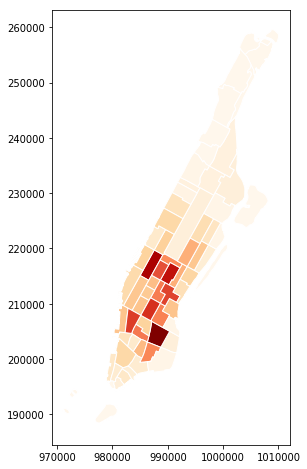

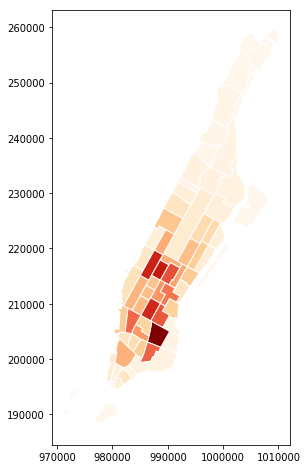

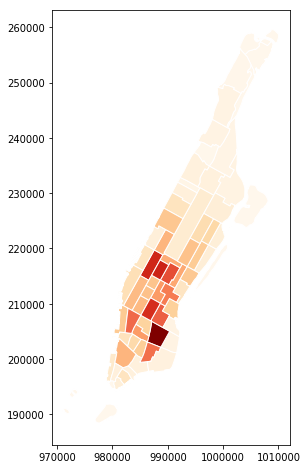

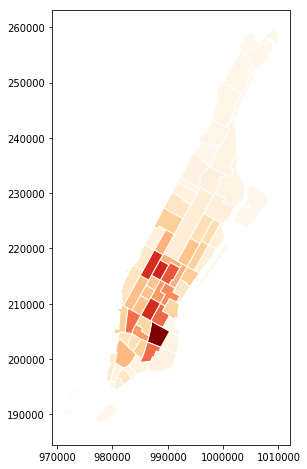

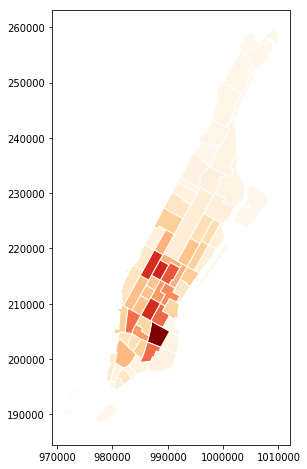

In [64]:
for group_name, group_data in valid_pred_5min.groupby(['tpep_pickup_5min_id']):
    print('group_name:', group_name)
    valid_pred_5min_group = group_data.groupby(['LocationID']).sum()[['value', 'pred_xgb', 'pred_lr', 'pred_tf', 'pred_lgb']]
    taxi_zones_shape_requests_pred_5min = taxi_zones_shape.join(valid_pred_5min_group, on=['LocationID'], how='left')
    taxi_zones_shape_requests_pred_5min.fillna(0, inplace=True)
    taxi_zones_shape_requests_pred_5min.plot(column='value', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_xgb', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lr', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_tf', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lgb', cmap='OrRd', edgecolor='white')

    break

In [65]:
valid_pred_5min_group

,value,pred_xgb,pred_lr,pred_tf,pred_lgb
LocationID,,,,,
4,4.000,2.099,2.108,2.247,2.247
12,0.000,0.009,-0.024,-0.047,-0.047
13,8.000,6.529,7.915,6.532,6.532
24,3.000,1.678,1.503,1.406,1.406
41,3.000,3.483,3.644,3.434,3.434
42,3.000,2.067,1.742,1.986,1.986
43,4.000,6.362,6.830,5.619,5.619
45,6.000,3.080,3.553,2.753,2.753
48,57.000,53.209,55.879,54.404,54.404


In [70]:
# show evaluate result
print('valid_5min_xgb_mae:', valid_5min_xgb_mae)
print('valid_5min_lr_mae:', valid_5min_lr_mae)
print('valid_5min_tf_mae:', valid_5min_tf_mae)
print('valid_5min_lgb_mae:', valid_5min_lgb_mae)

print('valid_15min_xgb_mae:', valid_15min_xgb_mae)
print('valid_15min_lr_mae:', valid_15min_lr_mae)
print('valid_15min_tf_mae:', valid_15min_tf_mae)
print('valid_15min_lgb_mae:', valid_15min_lgb_mae)

print('valid_30min_xgb_mae:', valid_30min_xgb_mae)
print('valid_30min_lr_mae:', valid_30min_lr_mae)
print('valid_30min_tf_mae:', valid_30min_tf_mae)
print('valid_30min_lgb_mae:', valid_30min_lgb_mae)

valid_5min_xgb_mae: 2.5705001477478713
valid_5min_lr_mae: 2.6854349833412017
valid_5min_tf_mae: 2.6854349833412017
valid_5min_lgb_mae: 2.6043024998629036
valid_15min_xgb_mae: 5.462757438580058
valid_15min_lr_mae: 6.341742248849771
valid_15min_tf_mae: 6.341742248849771
valid_15min_lgb_mae: 5.603619223969387
valid_30min_xgb_mae: 9.74837309250694
valid_30min_lr_mae: 12.337156081269177
valid_30min_tf_mae: 12.337156081269177
valid_30min_lgb_mae: 10.120641728407225


## Conclusion

The validate results show that XGBoost performs better than other algorithms. We can improve the results by adding more features and carefully tuning the parameters of the algorithm.